# General Mixture Models

author: Jacob Schreiber <br>
contact: jmschreiber91@gmail.com

It is frequently the case that the data you have is not explained by a single underlying distribution. If we want to try to recover the underlying distributions, we need to have a model which has multiple components. An example is the following data.

In [1]:
from pomegranate import *
%pylab inline
import numpy as np

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


(array([   5.,    4.,    9.,   17.,   22.,   26.,   29.,   29.,   27.,
          24.,   18.,   17.,   26.,   74.,  101.,  125.,  114.,   54.,
          23.,    6.]),
 array([ -4.83554563,  -4.01809789,  -3.20065015,  -2.38320241,
         -1.56575467,  -0.74830693,   0.06914082,   0.88658856,
          1.7040363 ,   2.52148404,   3.33893178,   4.15637952,
          4.97382727,   5.79127501,   6.60872275,   7.42617049,
          8.24361823,   9.06106597,   9.87851372,  10.69596146,  11.5134092 ]),
 <a list of 20 Patch objects>)

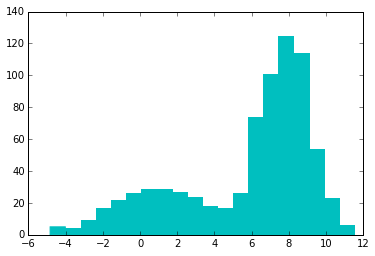

In [2]:
data = np.concatenate( (np.random.randn(250) * 2.75 + 1.25, np.random.randn(500) * 1.2 + 7.85) )
np.random.shuffle(data)
plt.hist( data, edgecolor='c', color='c', bins=20 )

We can create our initial estimate of what this distribution is a General Mixture Model. This is a model which is comprised of multiple distributions, and weights on those distributions representing the prior probability of a point falling under that distribution given no knowledge of the point itself (defaults to equal). We can have univariate mixture models by using univariate distributions, or multivariate distributions by using multivariate distributions.

## Gaussian Mixture Models

In [3]:
d = GeneralMixtureModel( [NormalDistribution(2.5, 1), NormalDistribution(8, 1)] )

We can now predict the class labels of each point under this mixture. 

In [4]:
labels = d.predict( data )
print labels[:5]
print "{} 1 labels, {} 0 labels".format( labels.sum(), labels.shape[0] - labels.sum() )

[0 1 1 1 1]
515 1 labels, 235 0 labels


This is fairly close to the number of underlying points from each distribution, off by 17 in each label. We still don't know if the labels are accurate, just the number of labels.

(array([ 10.,  15.,  29.,  31.,  40.,  34.,  46.,  49.,  41.,  44.,  53.,
         39.,  26.,  21.,  12.,  14.,   5.,   1.,   4.,   1.]),
 array([  5.33167774,   5.64076432,   5.94985089,   6.25893746,
          6.56802403,   6.87711061,   7.18619718,   7.49528375,
          7.80437033,   8.1134569 ,   8.42254347,   8.73163004,
          9.04071662,   9.34980319,   9.65888976,   9.96797633,
         10.27706291,  10.58614948,  10.89523605,  11.20432263,  11.5134092 ]),
 <a list of 20 Patch objects>)

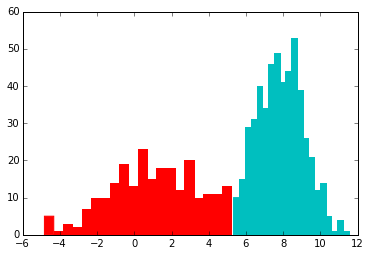

In [5]:
plt.hist( data[ labels == 0 ], edgecolor='r', color='r', bins=20 )
plt.hist( data[ labels == 1 ], edgecolor='c', color='c', bins=20 )

It is slightly more difficult to update the underlying components of the model because we don't have labels indicating which point came from which distribution. We could try to use the labels inferred from the model. It seems to cleanly split it, but what if our initial estimate was not very good? It could be difficult to get a good update if we had a bad prior. 

Another possibility is to predict the probability of each point under each component, to get a softer estimate of the labels. Lets take a look.

In [6]:
labels = d.predict_proba( data )
print labels[:5]
print labels.sum(axis=0)

[[  9.99999326e-01   6.73917051e-07]
 [  2.38136362e-05   9.99976186e-01]
 [  2.46138721e-07   9.99999754e-01]
 [  5.51649439e-08   9.99999945e-01]
 [  2.34775960e-08   9.99999977e-01]]
[ 235.09543917  514.90456083]


This is slightly closer to the truth, with 15.2 off instead of 17, around 10% closer.

This is the beginning of a common unsupervised training algorithm called <b>expectation maximization</b>. It has two steps, <b>expectation</b> and <b>maximization</b>. The <b>expectation</b> step involves what we just did--assigning weights based on the probability of each point being generated by each component. The next step, <b>maximization</b>, is maximizing the probability that the distribution generated these points but performing weighted MLE.

This process must be iterated until convergence. Sometimes this requires only a single update, but for overlapping distributions (such as this one) it can sometimes take many iterations.

In [7]:
d.fit( data, verbose=True )

Improvement: 672.548539948
Improvement: 1.11006819652
Improvement: 0.048991049149


673.7075991936529

## Multivariate Gaussian Mixture Models

We can do the same with multivariate distributions just as easily.

In [8]:
mu = np.arange(5)
cov = np.eye(5)

mgs = [ MultivariateGaussianDistribution( mu*i, cov ) for i in range(5) ]
gmm = GeneralMixtureModel( mgs )

In [9]:
data = numpy.random.randn(1000, 5) * 5
for i in range(5):
    data[i::5] += np.arange(5)*i

Lets see how well some points fit under the mixture model.

In [10]:
for i in range(10):
    print "Point {}: logp {}".format( i, gmm.log_probability(data[i]) )

Point 0: logp -54.2432049911
Point 1: logp -58.7376787433
Point 2: logp -55.5658683262
Point 3: logp -60.058092725
Point 4: logp -21.1505547075
Point 5: logp -48.7461810402
Point 6: logp -108.86934951
Point 7: logp -93.9401806118
Point 8: logp -77.2762765255
Point 9: logp -28.1452096613


In [11]:
gmm.fit(data, verbose=True, stop_threshold=1)

Improvement: 44836.3846858
Improvement: 26.3183190242
Improvement: 9.31763524395
Improvement: 4.84279408387
Improvement: 3.02138286129
Improvement: 2.11994980355
Improvement: 1.62766524951
Improvement: 1.33875577215
Improvement: 1.14979697329
Improvement: 1.00506071644
Improvement: 0.881879883354


44888.007925428814

Now lets see how well the previous points fit.

In [12]:
for i in range(10):
    print "Point {}: logp {}".format( i, gmm.log_probability(data[i]) )

Point 0: logp -16.8393482786
Point 1: logp -15.7632585926
Point 2: logp -15.4358024581
Point 3: logp -15.7162539199
Point 4: logp -14.4100297071
Point 5: logp -15.4738765588
Point 6: logp -17.4921505646
Point 7: logp -17.3052481578
Point 8: logp -16.1971703404
Point 9: logp -14.1796020623


Looks like they're being fit significantly better than before! Training works.

## Discrete Mixture Models

In addition to having general mixture models over continuous distributions, we can also have mixture models over discrete distributions. This is useful in many bioinformatics contexts, specifically sequence analysis. Lets use the toy analysis of trying to analyze CG island distribution.

The problem is the following; DNA is made up of long sequences the four canonical nucleotides, abbreviated 'A', 'C', 'G', and 'T'. These nucleotides are not distributed randomly, and there is significant amounts of structure in the sequence. A major field in bioinformatics is trying to interpret this structure. One structured element is the CG content, where the Cs and the Gs appear more commonly than in the background. If we want to try to determine CG percentages in these islands, we can use a mixture model.

In [13]:
d1 = DiscreteDistribution( {'A' : 0.25, 'C': 0.25, 'G' : 0.25, 'T': 0.25 } ) # Background
d2 = DiscreteDistribution( {'A' : 0.05, 'C': 0.45, 'G' : 0.45, 'T': 0.05 } ) # CG rich regions
gmm = GeneralMixtureModel( [d1, d2] )

In [14]:
seq = numpy.array(list('CGACATCTGACTACGGCGCGCCTACTACTTGATCGATACGGCGTCAGCGACGACGATGATCGGCATCAGTCACTAC'))
gmm.fit(seq)

3.4766541840931495

In [15]:
print gmm.distributions
print
print numpy.exp(gmm.weights)

[{
    "frozen" : false,
    "class" : "Distribution",
    "parameters" : [
        {
            "A" : 0.35000000000000009,
            "C" : 0.19999999999999993,
            "T" : 0.29166666666666674,
            "G" : 0.15833333333333327
        }
    ],
    "name" : "DiscreteDistribution"
}, {
    "frozen" : false,
    "class" : "Distribution",
    "parameters" : [
        {
            "A" : 0.090517241379310304,
            "C" : 0.46551724137931033,
            "T" : 0.075431034482758591,
            "G" : 0.36853448275862077
        }
    ],
    "name" : "DiscreteDistribution"
}]

[ 0.56390977  0.43609023]


Looks like in this case the concept was sound, that there many CG rich regions, but our initial estimates of the  percentages were off. We can use a GMM like the one above to both identify and study the composition of these regions at the same time, updating the parameters of the distributions using expectation-maximization. We will go into a more complex way of dong this using HMMs in the next tutorial.

## Serialization

General Mixture Models support serialization to JSONs using `to_json()` and `from_json( json )`. This is useful is you want to train a GMM on large amounts of data, taking a significant amount of time, and then use this model in the future without having to repeat this computationally intensive step.

In [16]:
print gmm.to_json()

{
    "weights" : [
        -0.5728610146854435,
        -0.8299061176753344
    ],
    "distributions" : [
        "{\n    \"frozen\" : false,\n    \"class\" : \"Distribution\",\n    \"parameters\" : [\n        {\n            \"A\" : 0.35000000000000009,\n            \"C\" : 0.19999999999999993,\n            \"T\" : 0.29166666666666674,\n            \"G\" : 0.15833333333333327\n        }\n    ],\n    \"name\" : \"DiscreteDistribution\"\n}",
        "{\n    \"frozen\" : false,\n    \"class\" : \"Distribution\",\n    \"parameters\" : [\n        {\n            \"A\" : 0.090517241379310304,\n            \"C\" : 0.46551724137931033,\n            \"T\" : 0.075431034482758591,\n            \"G\" : 0.36853448275862077\n        }\n    ],\n    \"name\" : \"DiscreteDistribution\"\n}"
    ],
    "class" : "GeneralMixtureModel"
}


Not the prettiest thing to look at right now. However, we can easily load it and use it immediately.

In [17]:
gmm_2 = GeneralMixtureModel.from_json( gmm.to_json() )
gmm_2.distributions

[{
     "frozen" : false,
     "class" : "Distribution",
     "parameters" : [
         {
             "A" : 0.3500000000000001,
             "C" : 0.19999999999999993,
             "T" : 0.29166666666666674,
             "G" : 0.15833333333333327
         }
     ],
     "name" : "DiscreteDistribution"
 }, {
     "frozen" : false,
     "class" : "Distribution",
     "parameters" : [
         {
             "A" : 0.0905172413793103,
             "C" : 0.46551724137931033,
             "T" : 0.07543103448275859,
             "G" : 0.3685344827586208
         }
     ],
     "name" : "DiscreteDistribution"
 }]

`gmm_2` is now ready to go, as if it was the original model!

## Concluding Remarks

General Mixture Models are extremely powerful tools for unsupervised learning. pomegranate makes it easy to define, fit, and make predictions using these models. All the examples above have used the same distribution type for all the components of the mixture, but that is not a requirement, if your application requires varied distributions.